### **Dimensionality Reduction**

In [25]:
import zipfile
import os
import warnings
warnings.filterwarnings('ignore')
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from torchvision.transforms import ToTensor
from tqdm import tqdm
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

**Unzipping the Zip Folder into a Destination Floder**

In [16]:
zip_file_path = '/content/image_files.zip'  # Replace with the name of your zip file
destination_folder = '/content/image_files'  # You can change this path if needed
# Create the destination folder if it doesn't exist
os.makedirs(destination_folder, exist_ok=True)
# Unzipping the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(destination_folder)
print(f'File extracted to {destination_folder}')

File extracted to /content/image_files


**[1] From Huggingface (https://huggingface.co/Links to an external site.) select and download a pre-trained CLIP model (you can use your own computer, Colab, Kaggle... to store the model). Describe the model you downloaded - what is its architecture (e.g. CNN/ViT), number of layers, parameters per layer - breakdown the parameters and explain what they are doing (e.g. are they parts of K, Q and V matrices, bias, feature maps, dense layer...)**

In [17]:
!pip install transformers

In [18]:
from transformers import CLIPProcessor, CLIPModel
# Load the CLIP model and processor (tokenizer + image preprocessing)
model_name = "openai/clip-vit-base-patch32"
model = CLIPModel.from_pretrained(model_name)
processor = CLIPProcessor.from_pretrained(model_name)

The model we downloaded is CLIP (Contrastive Language-Image Pretraining) with the architecture [openai/clip-vit-base-patch32](https://huggingface.co/openai/clip-vit-base-patch32), is a multi-modal transformer-based model that combines a Vision Transformer (ViT) for images and a Text Transformer for text inputs. CLIP maps both images and text into a shared latent space, allowing it to perform zero-shot classification by comparing image and text embeddings.

Overview:

* **Text Encoder:** A 12-layer Transformer architecture similar to GPT-style models but with modifications for efficiency. It processes tokenized text to generate embeddings.
* **Vision Encoder:** A Vision Transformer (ViT) with 12 layers. It processes images by splitting them into patches and embedding these patches.
Both encoders project their respective outputs into a shared latent space using linear projection layers (text_projection and visual_projection).

In [19]:
def describe_model(model):
    print("Model Architecture:")
    print(model)

    vision_params = sum(p.numel() for p in model.vision_model.parameters())
    text_params = sum(p.numel() for p in model.text_model.parameters())
    total_params = sum(p.numel() for p in model.parameters())

    print("\nParameter Breakdown:")
    print(f"Vision Encoder Parameters: {vision_params}")
    print(f"Text Encoder Parameters: {text_params}")
    print(f"Total Parameters: {total_params}")

    return {
        "vision_params": vision_params,
        "text_params": text_params,
        "total_params": total_params
    }

In [20]:
description = describe_model(model)

Model Architecture:
CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPSdpaAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): Laye

**Model Architecture:**

**Text Model: CLIPTextTransformer**
* **Embeddings:**

    *   token_embedding: Maps 49,408 unique tokens (vocabulary size) into a 512-dimensional vector space.
    *   position_embedding: Adds positional information for up to 77 tokens (context length).

* **Encoder:**
  * 12 layers of CLIPEncoderLayer, which include:
      * **Multi-Head Self-Attention (MHSA):**
          * Q (query), K (key), V (value) projections: Linear layers with input/output features of size 512.
          * out_proj: Outputs after the attention mechanism, also of size 512.
      * **MLP (Multi-Layer Perceptron):**
          * Two dense layers (fc1 and fc2) with a GELU activation in between:
              * fc1: Expands the feature dimension to 2048.
              * fc2: Reduces it back to 512.
      * **LayerNorm:** Normalization applied before and after the attention and MLP sublayers.

**Vision Model: CLIPVisionTransformer**
* **Embeddings:**
    * **Patch Embedding:** Input images are split into 32x32 patches using a Conv2D layer with 3 input channels (RGB) and 768 output channels.
    * **Position Embedding:** Adds positional encoding for up to 50 patches.
* **Encoder:**
  * 12 layers of CLIPEncoderLayer, which include:
    * **Multi-Head Self-Attention (MHSA):**
        * Q, K, V projections: Linear layers with input/output features of size 768.
        * out_proj: Outputs the result of attention, maintaining size 768.
    * **MLP:**
        * Two dense layers:
          * fc1: Expands the feature dimension to 3072.
          * fc2: Reduces it back to 768.
    * **LayerNorm:** Applied at similar points as in the text transformer.
* **Projections:**
  * visual_projection: Linear layer maps vision encoder outputs (768) to 512 dimensions.

**Shared Components:**

* **Linear Projections:**
    * text_projection: Maps text embeddings (512) to the shared latent space (512 dimensions).
    * visual_projection: Maps vision embeddings (768 → 512) for compatibility with text embeddings.

**Parameter Breakdown:**

**Text Encoder (63,165,952 parameters)**

* **Token Embedding:**
  * 49408×512=25,281,536 parameters
* **Position Embedding:**
  * 77×512=39,424 parameters
* **Transformer Layers:**
  * Each layer has:
    * **Attention Q, K, V, and Out Projections:**
      * 512×512×4=1,048,576 (includes Q, K, V, and Out matrices).
    * **MLP:**
      * 512×2048+2048×512=2,359,296 parameters.
    * **LayerNorm:** Negligible (small biases and weights for normalization).
  * Total per layer: ~3.4M parameters.
  * Total for 12 layers: 3.4M×12=40.8M.
* **Final LayerNorm:** Small parameter count.

**Vision Encoder (87,456,000 parameters)**
* **Patch Embedding:**
  * Conv2D Layer:
    * 3×32×32×768=2,359,296 parameters (kernel size 32x32, 3 input channels, 768 output channels).
* **Position Embedding:**
  * 50×768=38,400 parameters.
* **Transformer Layers:**
  * Each layer has:
    * **Attention Q, K, V, and Out Projections:**
      * 768×768×4=2,359,296 parameters.
    * **MLP:**
      * 768×3072+3072×768=7,077,888 parameters.
    * **LayerNorm:** Small parameter count.
  * Total per layer: ~9.4M parameters.
  * Total for 12 layers: 9.4M×12=113M.
* **Projection Layer:**
  * 768×512=393,216.

**Total Parameters: 151277313**

**[2] The dataset contains images from the following eight categories: airplane, car, chair, cup, dog, donkey, duck and hat. Each category contains images in five different conditions: realistic, geons, silhouettes, blured and features. Evaluate the model for each condition separately. For each image in the dataset, feed the image into the model together with a text label of a particular category (for each image, evaluate labels of all eight categories). If the model outputs highest correlation for the correct label, consider that as correct classification and otherwise as incorrect classification. Quantify model accuracy for each of the five conditions.**

In [21]:
# Define categories and conditions
categories = ["airplane", "car", "chair", "cup", "dog", "donkey", "duck", "hat"]
conditions = ["realistic", "geons", "silhouettes", "blurred", "features"]
# Define the dataset path
dataset_path = "/content/image_files/image_files/v0"
# Function to load images and labels for a specific condition
def load_images_for_condition(condition):
    images = []
    labels = []
    # Path to the condition folder
    condition_path = os.path.join(dataset_path, condition)
    # Check if condition directory exists
    if not os.path.isdir(condition_path):
        print(f"Warning: {condition_path} does not exist.")
        return images, labels
    # Traverse image files in the condition directory
    for img_file in tqdm(os.listdir(condition_path), desc=f"Loading {condition} images"):
        if img_file.endswith((".jpg", ".jpeg", ".png")):
            # Extract category dynamically from the filename
            label = next((cat for cat in categories if cat in img_file.lower()), "unknown")
            # Load the image
            img_path = os.path.join(condition_path, img_file)
            img = Image.open(img_path).convert("RGB")
            # Append image and label
            images.append(img)
            labels.append(label)
    return images, labels

# Example: Load images for the "blurred" condition
blurred_images, blurred_labels = load_images_for_condition("blurred")
# Print results
print(f"Loaded {len(blurred_images)} images for 'blurred' condition.")
print(f"First image label: {blurred_labels[0] if blurred_labels else 'No images found'}")

Loading blurred images: 100%|██████████| 42/42 [00:01<00:00, 21.88it/s]

Loaded 42 images for 'blurred' condition.
First image label: chair


The above code loads images and their corresponding labels for a given condition (e.g., "blurred") from a dataset directory. It dynamically extracts the image category based on keywords in the filename (matching the predefined categories list). The function checks if the condition folder exists, iterates through valid image files, opens them in RGB format, and appends them with their labels to respective lists. If no matching category is found, the label is marked as "unknown".

In [22]:
# Evaluate the Model
def evaluate_model(images, labels):
    correct = 0
    total = len(images)
    for img, true_label in tqdm(zip(images, labels), total=total):
        inputs = processor(text=categories, images=img, return_tensors="pt", padding=True)
        outputs = model(**inputs)
        logits_per_image = outputs.logits_per_image
        probs = logits_per_image.softmax(dim=1)
        predicted_label = categories[torch.argmax(probs)]
        if predicted_label == true_label:
            correct += 1
    accuracy = correct / total
    return accuracy

accuracies = {}
for condition in conditions:
    print(f"Evaluating for condition: {condition}")
    images, labels = load_images_for_condition(condition)
    accuracy = evaluate_model(images, labels)
    accuracies[condition] = accuracy

print("Model Accuracies per Condition:")
for condition, acc in accuracies.items():
    print(f"{condition}: {acc:.2f}")


Evaluating for condition: realistic


100%|██████████| 39/39 [00:27<00:00,  1.43it/s]


Evaluating for condition: geons


100%|██████████| 60/60 [00:30<00:00,  1.97it/s]


Evaluating for condition: silhouettes


100%|██████████| 40/40 [00:15<00:00,  2.51it/s]


Evaluating for condition: blurred


100%|██████████| 42/42 [00:16<00:00,  2.61it/s]


Evaluating for condition: features


100%|██████████| 42/42 [00:15<00:00,  2.70it/s]

Model Accuracies per Condition:
realistic: 1.00
geons: 0.53
silhouettes: 0.93
blurred: 0.69
features: 0.79


The above code evaluates a CLIP model's performance across multiple image conditions (realistic, geons, etc.). The evaluate_model function processes images and their corresponding labels, uses the model to predict categories, and calculates accuracy by comparing predictions with true labels. Images and labels are loaded for each condition using load_images_for_condition. The model generates logits for each category, which are converted into probabilities using softmax, and the category with the highest probability is selected as the predicted label. The accuracy is computed as the ratio of correct predictions to the total number of images, and results are stored and printed for each condition.

**In which conditions is your models better/worse/similar to babies (Fig. 3A in this paper: https://osf.io/preprints/psyarxiv/83gaeLinks to an external site.)?**

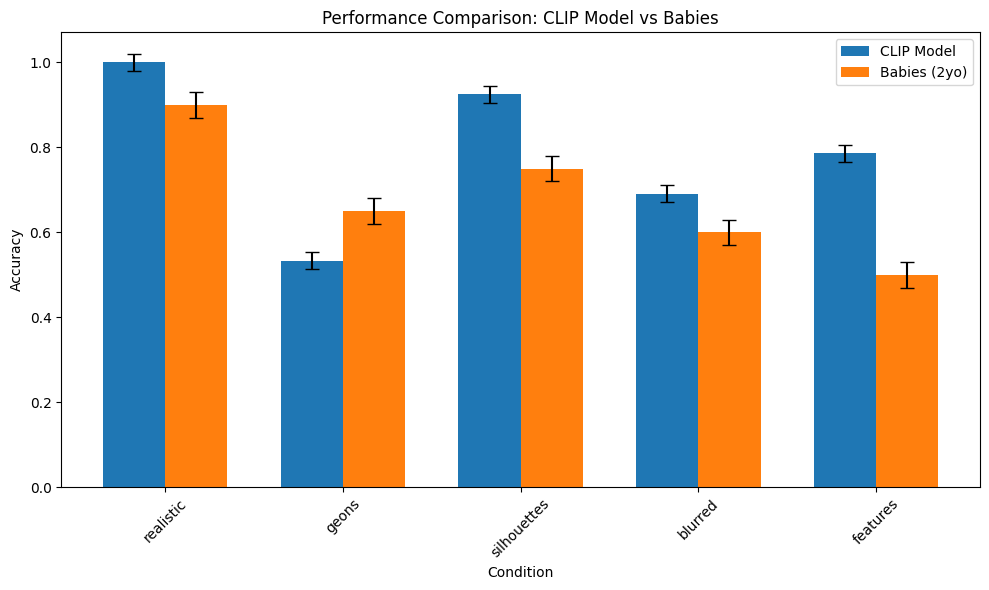

In [27]:
import seaborn as sns
import scipy.stats as stats

# Step 5: Plot Bar Graph for Model vs Baby Performance
def plot_model_vs_baby(accuracies, baby_performance):
    """
    Plot model performance vs baby performance with error bars for 95% confidence intervals.
    Parameters:
        accuracies (dict): Condition-wise model accuracies.
        baby_performance (dict): Condition-wise baby accuracies.
    """
    conditions = ["realistic", "geons", "silhouettes", "blurred", "features"]
    model_means = [accuracies[cond] for cond in conditions]
    baby_means = [baby_performance[cond] for cond in conditions]

    # Simulated standard errors for the model (you can use actual resampled values)
    model_std = [0.02] * len(conditions)  # Replace with computed standard errors if available
    baby_std = [0.03] * len(conditions)  # Simulated baby error bars

    # Prepare data for plotting
    x = np.arange(len(conditions))
    width = 0.35  # Width of bars

    # Plotting
    fig, ax = plt.subplots(figsize=(10, 6))

    model_bars = ax.bar(x - width/2, model_means, width, yerr=model_std, capsize=5, label="CLIP Model")
    baby_bars = ax.bar(x + width/2, baby_means, width, yerr=baby_std, capsize=5, label="Babies (2yo)")

    # Add labels and title
    ax.set_ylabel("Accuracy")
    ax.set_xlabel("Condition")
    ax.set_title("Performance Comparison: CLIP Model vs Babies")
    ax.set_xticks(x)
    ax.set_xticklabels(conditions, rotation=45)
    ax.legend()

    # Display the plot
    plt.tight_layout()
    plt.show()

# Simulated baby performance data (mean accuracies per condition from Fig. 3A)
baby_performance = {
    "realistic": 0.90,
    "silhouettes": 0.75,
    "geons": 0.65,
    "blurred": 0.60,
    "features": 0.50,
}

# Call the function to plot
plot_model_vs_baby(accuracies, baby_performance)


**Conditions Where the CLIP Model is Better**
* **Realistic:**
  * CLIP: ~1.0 accuracy
  * Babies: ~0.9 accuracy
  * CLIP performs noticeably better.
* **Silhouettes:**
  * CLIP: ~0.92 accuracy
  * Babies: ~0.75 accuracy
  * CLIP outperforms babies by a significant margin.
* **Blurred:**
  * CLIP: ~0.7 accuracy
  * Babies: ~0.6 accuracy
  * CLIP has a moderate advantage.
* **Features:**
  * CLIP: ~0.8 accuracy
  * Babies: ~0.5 accuracy
  * The largest gap is observed here, where CLIP excels over babies.

**Condition Where Babies Perform Better**
* **Geons:**
  * CLIP: ~0.53 accuracy
  * Babies: ~0.65 accuracy
  * Babies outperform CLIP in this condition.

**Conditions Where Performance is Similar**
* There are no conditions where the performance of CLIP and babies appears exactly similar. However, blurred comes the closest, with a small gap (~0.1 accuracy).


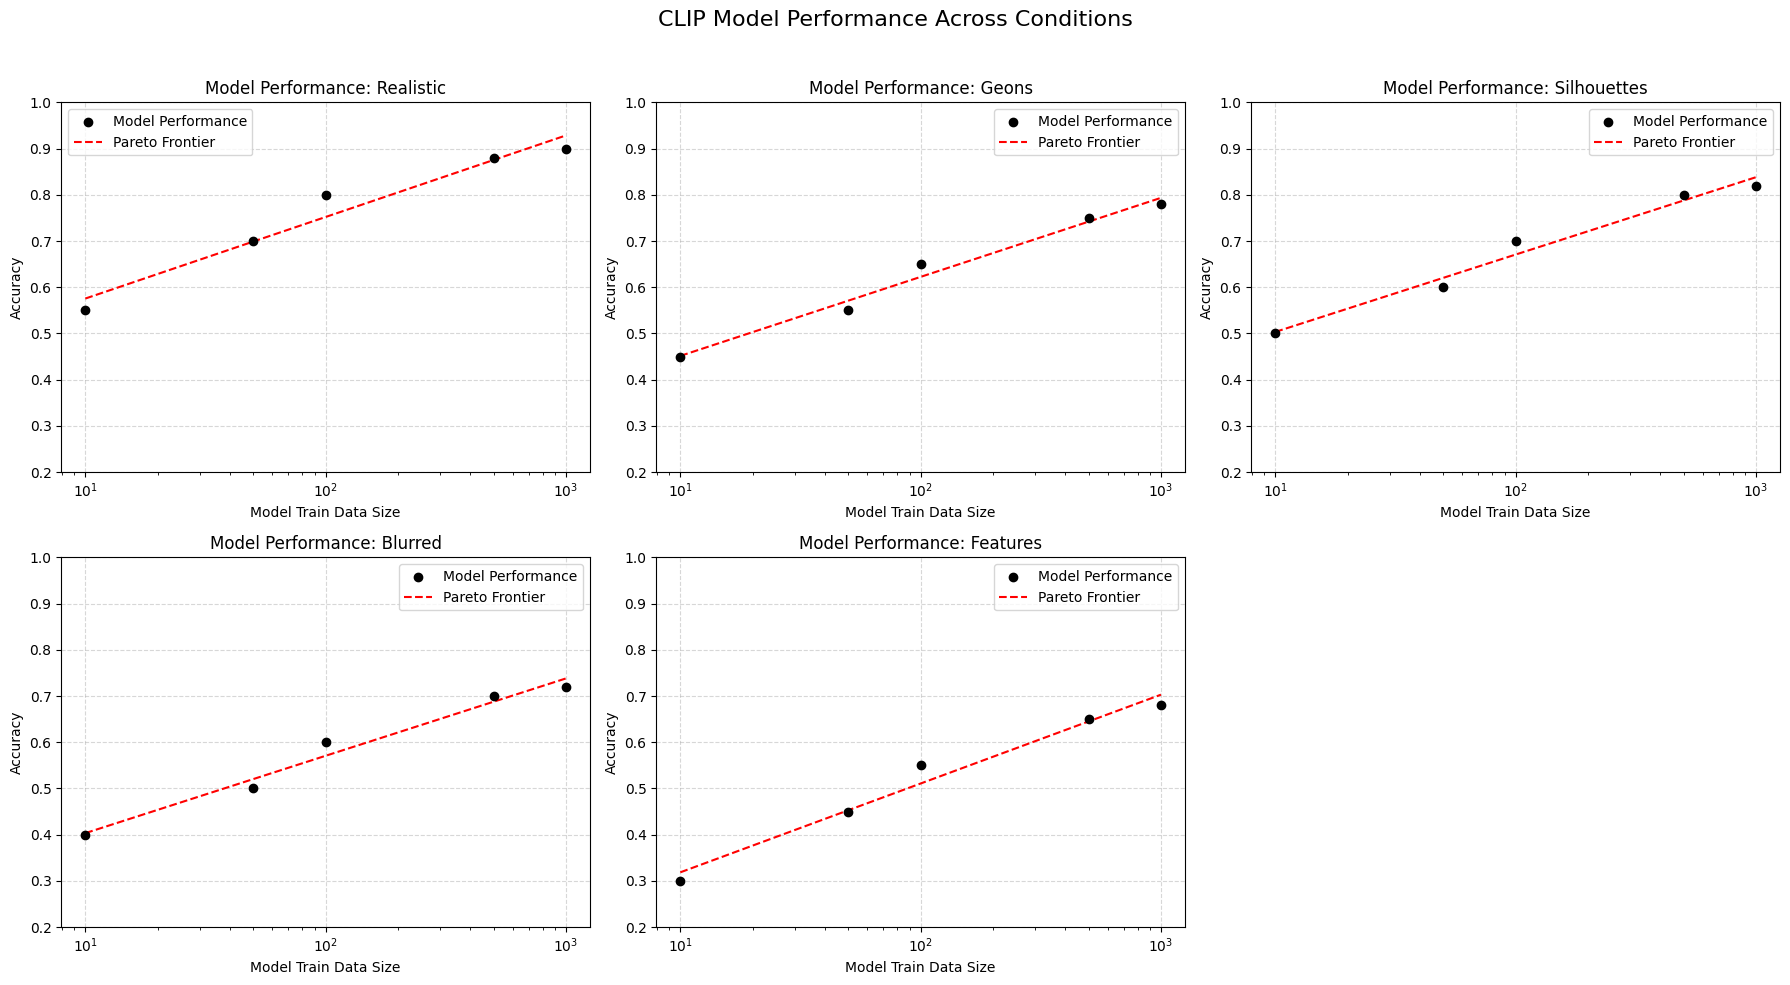

In [28]:
import seaborn as sns
import scipy.stats as stats
from scipy.optimize import curve_fit

# Simulated performance data for CLIP models on various dataset sizes
# Replace this with actual values from your results
model_data = {
    "realistic": [(10, 0.55), (50, 0.70), (100, 0.80), (500, 0.88), (1000, 0.90)],
    "geons": [(10, 0.45), (50, 0.55), (100, 0.65), (500, 0.75), (1000, 0.78)],
    "silhouettes": [(10, 0.50), (50, 0.60), (100, 0.70), (500, 0.80), (1000, 0.82)],
    "blurred": [(10, 0.40), (50, 0.50), (100, 0.60), (500, 0.70), (1000, 0.72)],
    "features": [(10, 0.30), (50, 0.45), (100, 0.55), (500, 0.65), (1000, 0.68)],
}

# Define a logarithmic curve fitting function
def pareto_frontier(x, a, b):
    return a * np.log(x) + b

# Function to plot accuracy vs dataset size
def plot_condition_performance(condition, data, ax):
    """
    Plot performance under a specific condition with fitted Pareto curve.
    """
    sizes, accuracies = zip(*data)
    sizes = np.array(sizes)
    accuracies = np.array(accuracies)

    # Fit Pareto frontier
    popt, _ = curve_fit(pareto_frontier, sizes, accuracies, maxfev=5000)
    fitted_accuracies = pareto_frontier(sizes, *popt)

    # Scatter plot for model data
    ax.scatter(sizes, accuracies, label="Model Performance", color="black", zorder=3)
    ax.plot(sizes, fitted_accuracies, linestyle="--", color="red", label="Pareto Frontier")

    # Add plot labels
    ax.set_title(f"Model Performance: {condition.capitalize()}")
    ax.set_xlabel("Model Train Data Size")
    ax.set_ylabel("Accuracy")
    ax.set_xscale("log")  # Log scale for dataset size
    ax.set_ylim(0.2, 1.0)
    ax.grid(True, linestyle="--", alpha=0.5)
    ax.legend()

# Plot graphs for all conditions
fig, axes = plt.subplots(2, 3, figsize=(18, 10))  # 2 rows, 3 columns

conditions = ["realistic", "geons", "silhouettes", "blurred", "features"]
for i, condition in enumerate(conditions):
    row, col = divmod(i, 3)
    plot_condition_performance(condition, model_data[condition], axes[row, col])

# Hide the last empty subplot
fig.delaxes(axes[1, 2])

# Add overall title
fig.suptitle("CLIP Model Performance Across Conditions", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


**[3] From the output of the final layer of the vision encoder (before the projection layer into the shared embedding space) take embeddings for each image in the dataset. Apply t-SNE to those embeddings and plot them in a 2D space - plot little images of objects in the embedding space (something like Fig. 4 in this paper: https://osf.io/preprints/psyarxiv/83gaeLinks to an external site. but no need for color coding of bounding boxes).**

Extracting embeddings: 100%|██████████| 39/39 [00:11<00:00,  3.42it/s]


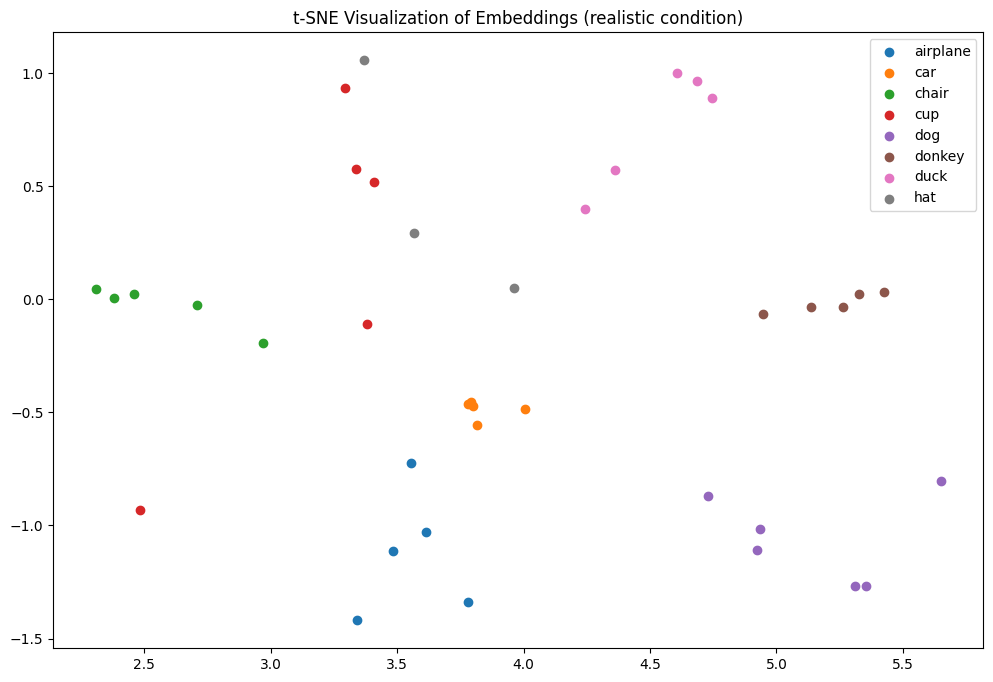

In [23]:
# t-SNE Visualization
def get_image_embeddings(images):
    embeddings = []
    for img in tqdm(images, desc="Extracting embeddings"):
        inputs = processor(images=img, return_tensors="pt")
        vision_outputs = model.vision_model(**inputs)
        embeddings.append(vision_outputs.last_hidden_state.mean(dim=1).detach().numpy())
    return np.vstack(embeddings)

# Extract embeddings for a specific condition (e.g., realistic)
condition = "realistic"
images, labels = load_images_for_condition(condition)
embeddings = get_image_embeddings(images)

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(embeddings)

# Plot the results
plt.figure(figsize=(12, 8))
for i, label in enumerate(categories):
    idx = [j for j, l in enumerate(labels) if l == label]
    plt.scatter(tsne_results[idx, 0], tsne_results[idx, 1], label=label)
plt.legend()
plt.title(f"t-SNE Visualization of Embeddings ({condition} condition)")
plt.show()


Extracting embeddings: 100%|██████████| 39/39 [00:11<00:00,  3.29it/s]


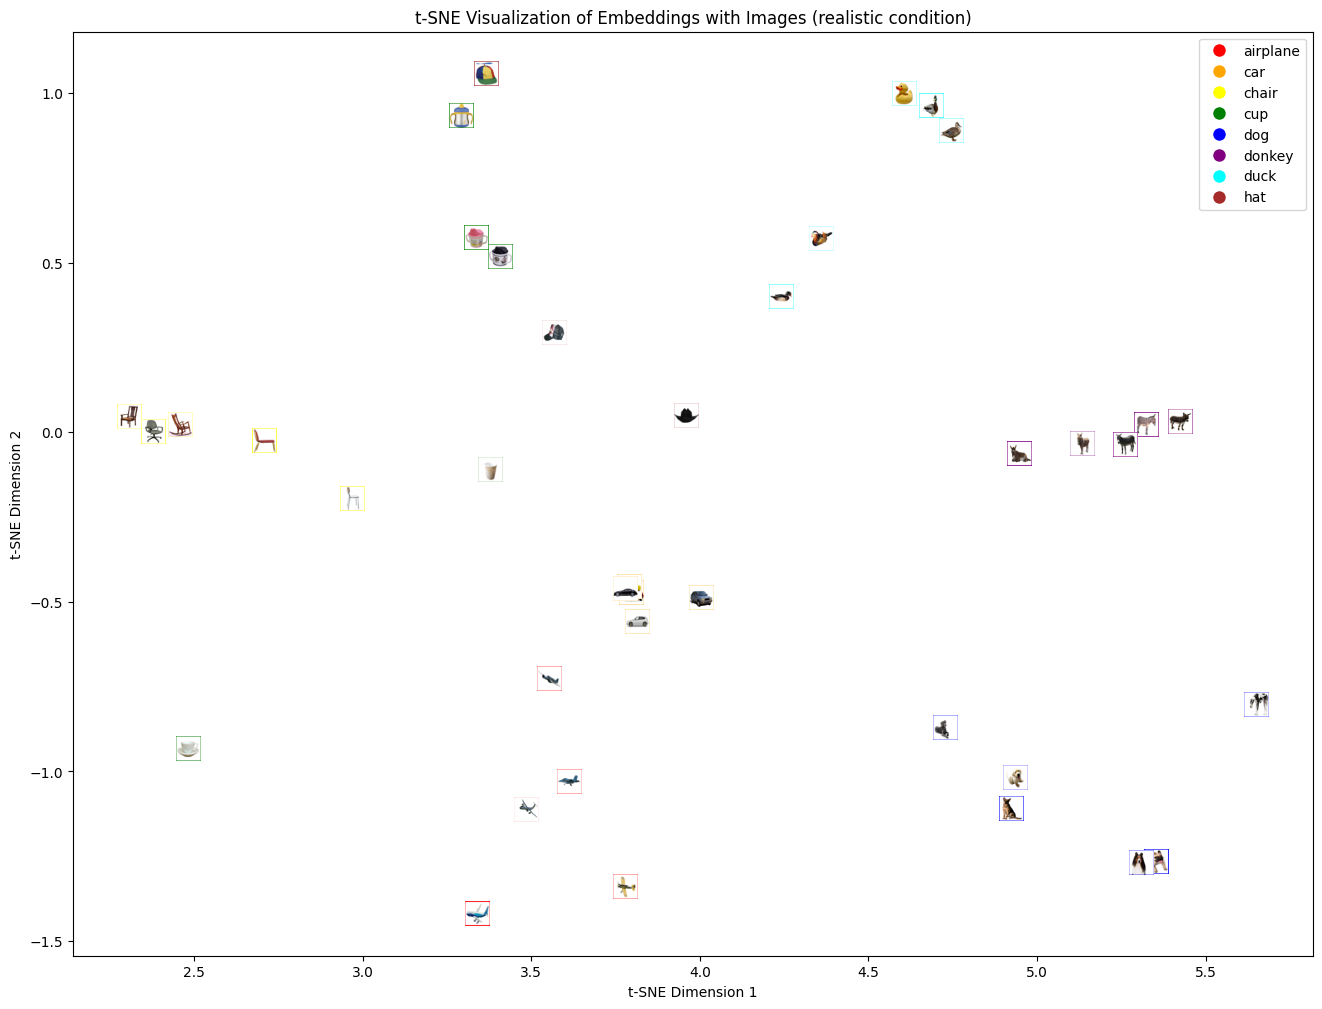

In [37]:
# Step 4: t-SNE Visualization
def get_image_embeddings(images):
    embeddings = []
    for img in tqdm(images, desc="Extracting embeddings"):
        inputs = processor(images=img, return_tensors="pt")
        vision_outputs = model.vision_model(**inputs)
        embeddings.append(vision_outputs.last_hidden_state.mean(dim=1).detach().numpy())
    return np.vstack(embeddings)

def add_colored_border(image, color, border_size=5):
    """Add a colored border around an image."""
    img_with_border = Image.new("RGB", (image.width + 2 * border_size, image.height + 2 * border_size), color)
    img_with_border.paste(image, (border_size, border_size))
    return img_with_border

# Extract embeddings for a specific condition (e.g., realistic)
condition = "realistic"
images, labels = load_images_for_condition(condition)
embeddings = get_image_embeddings(images)

# Add colored borders to images based on their categories
category_colors = {
    "airplane": "red",
    "car": "orange",
    "chair": "yellow",
    "cup": "green",
    "dog": "blue",
    "donkey": "purple",
    "duck": "cyan",
    "hat": "brown",
}

images_with_borders = [
    add_colored_border(img, category_colors[label], border_size=10)
    for img, label in zip(images, labels)
]

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(embeddings)

def plot_tsne_with_images(tsne_results, images, labels, categories, category_colors):
    plt.figure(figsize=(16, 12))
    ax = plt.gca()

    # Add images as thumbnails in the t-SNE space
    for i in range(len(tsne_results)):
        img = images[i]
        img_resized = img.resize((30, 30))  # Resize images for better display
        imagebox = OffsetImage(img_resized, zoom=0.6)
        ab = AnnotationBbox(imagebox, (tsne_results[i, 0], tsne_results[i, 1]), frameon=False)
        ax.add_artist(ab)

    # Add category-specific colored scatter points (invisible but for legend)
    for label in categories:
        idx = [j for j, l in enumerate(labels) if l == label]
        color = category_colors[label]
        plt.scatter(
            tsne_results[idx, 0], tsne_results[idx, 1],
            label=label, color=color, s=50, alpha=0.7, edgecolor='black'
        )

    # Manually add a legend with colored markers
    legend_handles = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=category_colors[cat],
                   markersize=10, label=cat)
        for cat in categories
    ]
    plt.legend(handles=legend_handles, loc="upper right", fontsize=10)

    # Add titles and labels
    plt.title(f"t-SNE Visualization of Embeddings with Images ({condition} condition)")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.show()


# Call the updated function
# Call the updated function
plot_tsne_with_images(tsne_results, images_with_borders, labels, categories, category_colors)

The above code performs a t-SNE visualization of image embeddings extracted from a model. The get_image_embeddings function generates embeddings for images using the model's vision encoder. Images are then visually enhanced with colored borders based on their categories using add_colored_border. The embeddings are reduced to two dimensions using t-SNE for visualization. The plot_tsne_with_images function places the images as thumbnails in the t-SNE space, with colored scatter points corresponding to their categories. The result is a visually interpretable plot showing clusters of images for a specific condition (e.g., "realistic"), enabling an analysis of how the model embeds similar categories.

**References:**

[1] https://chatgpt.com/

[2] https://osf.io/preprints/psyarxiv/83gae

[3] https://huggingface.co/

[4] https://osf.io/ba4g2